In [5]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [6]:

!nvidia-smi

Sun Sep 26 00:05:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

  Using cached https://github.com/wandb/client/archive/feature/code-save.zip
  Using cached GitPython-3.1.24-py3-none-any.whl (180 kB)
  Using cached gql-0.2.0-py3-none-any.whl
  Using cached shortuuid-1.0.1-py3-none-any.whl (7.5 kB)
  Using cached watchdog-2.1.5-py3-none-manylinux2014_x86_64.whl (75 kB)
  Using cached sentry_sdk-1.4.1-py2.py3-none-any.whl (139 kB)
  Using cached subprocess32-3.5.4-py3-none-any.whl
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached configparser-5.0.2-py3-none-any.whl (19 kB)
  Using cached graphql_core-1.1-py3-none-any.whl
  Using cached gitdb-4.0.7-py3-none-any.whl (63 kB)
  Using cached smmap-4.0.0-py2.py3-none-any.whl (24 kB)
  Created wheel for wandb: filename=wandb-0.8.36-py2.py3-none-any.whl size=1385054 sha256=b339406323a3bb4956a87beae5dce7cce35b4cb04ef1cb1ecee5ab421a89937d
  Stored in directory: /root/.cache/pip/wheels/08/1e/c2/b01dd11de70589ef2c6305c9b94da5bdfa22fd99b08da54fcf
Successfully built wandb


In [8]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [9]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [10]:

# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 35.18 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [11]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


In [12]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [13]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])


In [14]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [15]:
# Create TensorFlow dataset
BATCH_SIZE = 8

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [16]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [17]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2021-09-26 00:06:02--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]     891  --.-KB/s    in 0s      

2021-09-26 00:06:02 (34.7 MB/s) - ‘helpers.py’ saved [891/891]

--2021-09-26 00:06:02--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘losse

In [18]:
!sed -i '3 s/^/#/' helpers.py

In [19]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [20]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)


In [21]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [22]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

  1%|          | 1/100 [02:02<3:21:35, 122.17s/it]

epoch: 1 loss: 2.435


 11%|█         | 11/100 [14:32<1:51:33, 75.20s/it]

epoch: 11 loss: 1.428


 21%|██        | 21/100 [26:59<1:38:20, 74.70s/it]

epoch: 21 loss: 1.275


 31%|███       | 31/100 [39:26<1:25:53, 74.69s/it]

epoch: 31 loss: 1.225


 41%|████      | 41/100 [51:59<1:13:17, 74.54s/it]

epoch: 41 loss: 1.200


 51%|█████     | 51/100 [1:04:24<1:00:53, 74.56s/it]

epoch: 51 loss: 1.187


 61%|██████    | 61/100 [1:16:54<48:50, 75.14s/it]

epoch: 61 loss: 1.179


 71%|███████   | 71/100 [1:29:27<36:23, 75.28s/it]

epoch: 71 loss: 1.176


 81%|████████  | 81/100 [1:41:59<23:49, 75.23s/it]

epoch: 81 loss: 1.177


 91%|█████████ | 91/100 [1:54:31<11:15, 75.10s/it]

epoch: 91 loss: 1.169


100%|██████████| 100/100 [2:05:46<00:00, 75.47s/it]


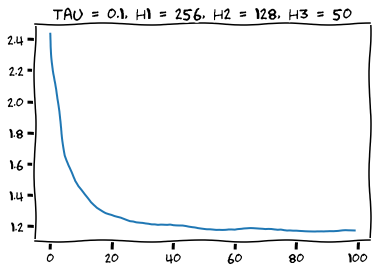

In [23]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=100)

with plt.xkcd():
    plt.plot(epoch_wise_loss)
    plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
    plt.show()

In [24]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"
filename

'20210926-021152resnet_simclr.h5'

In [25]:
resnet_simclr.save_weights(filename)

In [26]:

# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [27]:
# Train and test image paths
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [28]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [29]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [30]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

100%|██████████| 125/125 [00:00<00:00, 171.45it/s]


(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 190.76it/s]


(250, 224, 224, 3) (250,)


In [31]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [32]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(filename)
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [33]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [34]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [35]:

resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [36]:

# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [37]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
2/2 [==============================] - 1s 224ms/step - loss: 8.2986 - accuracy: 0.2720 - val_loss: 6.8094 - val_accuracy: 0.2400
Epoch 2/35
2/2 [==============================] - 0s 35ms/step - loss: 7.1347 - accuracy: 0.2720 - val_loss: 5.7856 - val_accuracy: 0.2360
Epoch 3/35
2/2 [==============================] - 0s 30ms/step - loss: 6.1352 - accuracy: 0.2880 - val_loss: 5.0061 - val_accuracy: 0.2720
Epoch 4/35
2/2 [==============================] - 0s 32ms/step - loss: 5.3646 - accuracy: 0.2640 - val_loss: 4.5568 - val_accuracy: 0.2520
Epoch 5/35
2/2 [==============================] - 0s 36ms/step - loss: 4.8429 - accuracy: 0.2560 - val_loss: 4.3662 - val_accuracy: 0.3120
Epoch 6/35
2/2 [==============================] - 0s 37ms/step - loss: 4.5789 - accuracy: 0.2800 - val_loss: 4.2769 - val_accuracy: 0.2760
Epoch 7/35
2/2 [==============================] - 0s 40ms/step - loss: 4.4330 - accuracy: 0.2800 - val_loss: 4.1966 - val_accuracy: 0.2560
Epoch 8/35
2/2 [==========

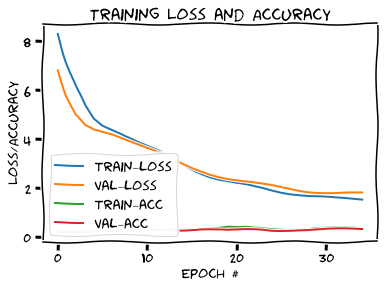

In [38]:
# Linear model

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [39]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


Epoch 1/35
2/2 [==============================] - 1s 176ms/step - loss: 6.7168 - accuracy: 0.2880 - val_loss: 5.4254 - val_accuracy: 0.3280
Epoch 2/35
2/2 [==============================] - 0s 35ms/step - loss: 5.9342 - accuracy: 0.3200 - val_loss: 4.9611 - val_accuracy: 0.3080
Epoch 3/35
2/2 [==============================] - 0s 37ms/step - loss: 5.3121 - accuracy: 0.3200 - val_loss: 4.6812 - val_accuracy: 0.3000
Epoch 4/35
2/2 [==============================] - 0s 34ms/step - loss: 4.9395 - accuracy: 0.3200 - val_loss: 4.3966 - val_accuracy: 0.2880
Epoch 5/35
2/2 [==============================] - 0s 45ms/step - loss: 4.5118 - accuracy: 0.3120 - val_loss: 4.0400 - val_accuracy: 0.2880
Epoch 6/35
2/2 [==============================] - 0s 33ms/step - loss: 4.0891 - accuracy: 0.3280 - val_loss: 3.6476 - val_accuracy: 0.2800
Epoch 7/35
2/2 [==============================] - 0s 33ms/step - loss: 3.6435 - accuracy: 0.3200 - val_loss: 3.2186 - val_accuracy: 0.3000
Epoch 8/35
2/2 [==========

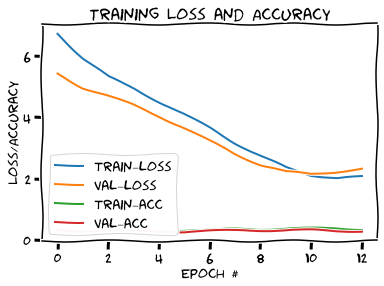

In [40]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [41]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


Epoch 1/35
2/2 [==============================] - 1s 185ms/step - loss: 2.2740 - accuracy: 0.2400 - val_loss: 2.0254 - val_accuracy: 0.2480
Epoch 2/35
2/2 [==============================] - 0s 33ms/step - loss: 2.1856 - accuracy: 0.2160 - val_loss: 1.6100 - val_accuracy: 0.2960
Epoch 3/35
2/2 [==============================] - 0s 34ms/step - loss: 1.5692 - accuracy: 0.3680 - val_loss: 1.6310 - val_accuracy: 0.3200
Epoch 4/35
2/2 [==============================] - 0s 44ms/step - loss: 1.6194 - accuracy: 0.3520 - val_loss: 1.8808 - val_accuracy: 0.2720
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


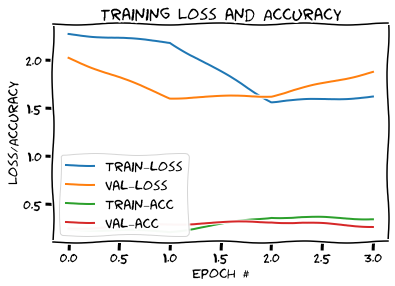

In [42]:
linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [43]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


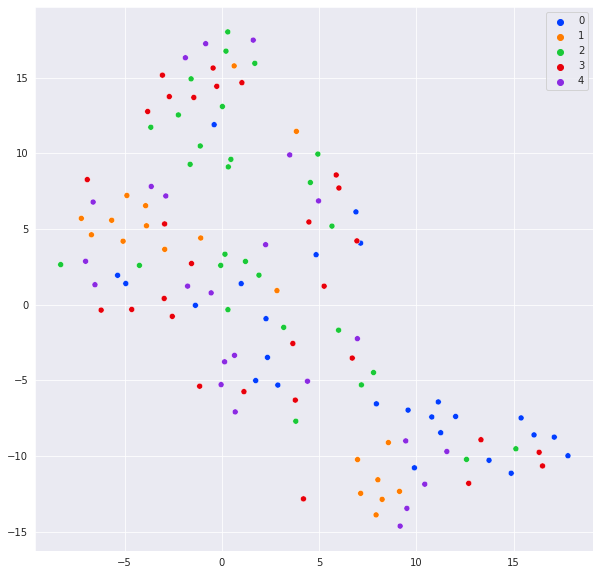

In [44]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


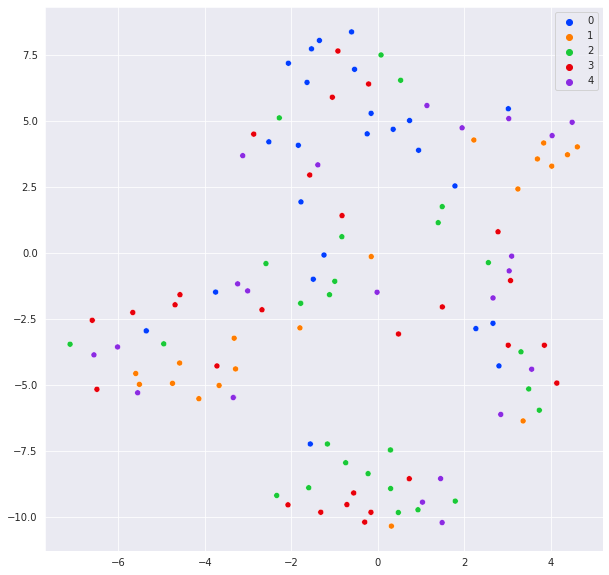

In [45]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


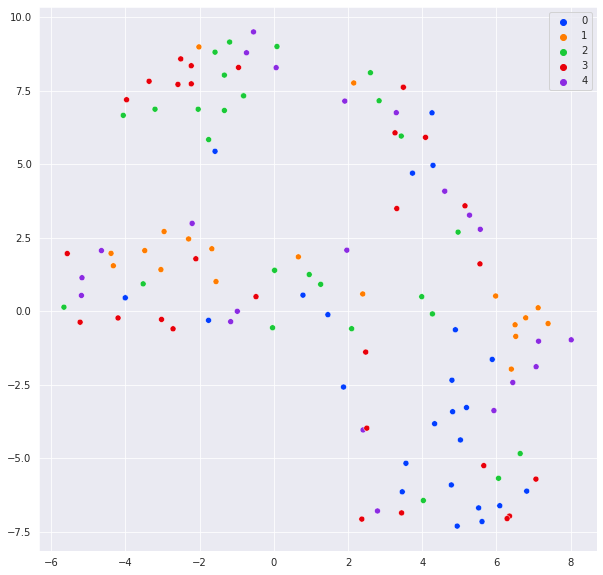

In [46]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)